In [34]:
!nvidia-smi

Mon Jan 10 01:12:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    57W / 149W |   2196MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = "/content/gdrive/MyDrive/University_of_Messina/Thesis/GAN"
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
! ls

cGAN.ipynb  gan_mnist.h5  GAN_Mnist.ipynb


In [4]:
from tensorflow.keras.datasets.fashion_mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
# Shape model
print('Train shape: ', X_train.shape, y_train.shape)
print('Test shape : ', X_test.shape, y_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
Train shape:  (60000, 28, 28) (60000,)
Test shape :  (10000, 28, 28) (10000,)


Tiếp theo chúng ta sẽ khảo sát ngẫu nhiên 10 hình ảnh thuộc bộ dữ liệu này :

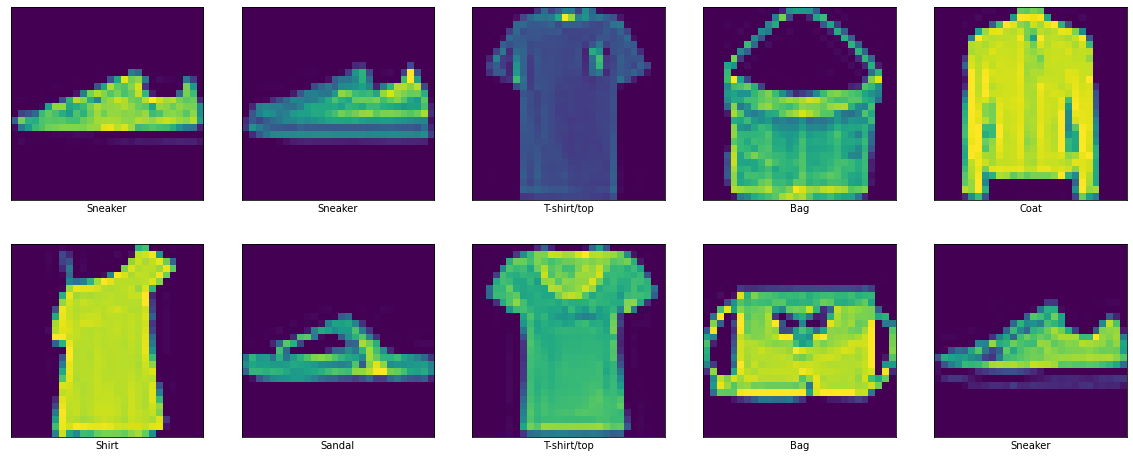

In [5]:
import matplotlib.pyplot as plt
import numpy as np


class_names = {
    0: "T-shirt/top",
  1: "Trouser/pants",
  2: "Pullover shirt",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

idxs = np.arange(X_train.shape[0])
plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(idxs, 10)):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx])
    # Nếu muốn show ảnh gray thì thay lệnh plt.imshow() ở trên bằng lệnh bên dưới.
    # plt.imshow(X_train[idx], c_map='gray_r')
    plt.xlabel(class_names[y_train[idx]])
plt.show()

Ta nhận thấy các bức ảnh đều có độ phân giải thấp để giảm thiểu khối lượng tính toán cho demo. Phông nền của hình ảnh là màu đen tương ứng với các điểm ảnh có giá trị cường độ là 0. Phần trung tâm của bức ảnh là các bộ quần áo, giày có giá trị cường độ lớn hơn 0.

**Discriminator**

Đầu vào của discriminator sẽ là một véc tơ concatenate giữa véc tơ biểu diễn ảnh với véc tơ one-hot của nhãn bức ảnh. Véc tơ one-hot của nhãn sau đó sẽ chiếu lên một không gian mới 50 chiều thông qua một phép chiếu linear-projection.

Backbone (tức là mạng CNN cơ sở) mà chúng ta sử dụng để huấn luyện model CGAN là một kiến trúc CNN thông thường làm nhiệm vụ trích suất các đặc trưng của ảnh. Bạn đọc có thể sử dụng thử bất kỳ một kiến trúc CNN model nào đã được trình bày tại Bài 38 - Các kiến trúc CNN hiện đại. Hoặc có thể tự tạo cho mình một kiến trúc CNN tùy ý. Việc tạo kiến trúc CNN là không quá khó khăn, chúng ta có thể sử dụng các block CNN [Conv + BatchNorm + Maxpooling] liên tiếp nhau để giảm chiều dữ liệu. Output của layer CNN cuối cùng sẽ được trải phẳng (flatten) thành một véc tơ và sử dụng các kết nối fully connected để thu được đầu ra với số lượng class mong muốn.

Bạn đọc sẽ hiểu rõ hơn qua phần thực hành bên dưới :

In [6]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, LeakyReLU, Embedding, Concatenate, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def _discriminator(input_shape=(28, 28, 1), n_classes = 10):
  # 1. Khởi tạo nhánh input là y_label
  y_label = Input(shape=(1,))
  # Embedding y_label và chiếu lên không gian véc tơ 50 dimension.
  y_embedding = Embedding(n_classes, 50)(y_label)
  # Gia tăng kích thước y_embedding thông qua linear projection
  n_shape = input_shape[0] * input_shape[1]
  li = Dense(n_shape)(y_embedding)
  li = Reshape((input_shape[0], input_shape[1], 1))(li)
  
  # 2. Khởi tạo nhánh input là image
  inpt_image = Input(shape=(28, 28, 1))
  
  # 3. Concate y_label và image
  concat = Concatenate()([inpt_image, li])
  # 4. Feature extractor thông qua CNN blocks:
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(concat)
  fe = LeakyReLU(alpha=0.2)(fe)
  
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  
  # Flatten output
  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  out_layer = Dense(1, activation='sigmoid')(fe)

  # Khởi tạo model
  model = Model([inpt_image, y_label], out_layer)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

Đồ thị của mô hình bên dưới cho chúng ta thấy rằng đầu vào của mô hình được concatenate từ hai nhánh. Một nhánh đọc dữ liệu từ các bức ảnh và một nhánh còn lại sẽ embedding nhãn thành một véc tơ 50 chiều. Sau khi concatenate dữ liệu thì chúng sẽ được truyền qua các CNN layer để trích lọc đặc trưng phục vụ cho mục đích phân loại ảnh real và fake. Đầu ra của mô hình discriminator chỉ bao gồm một unit dự báo xác suất thuộc về ảnh real hoặc fake.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


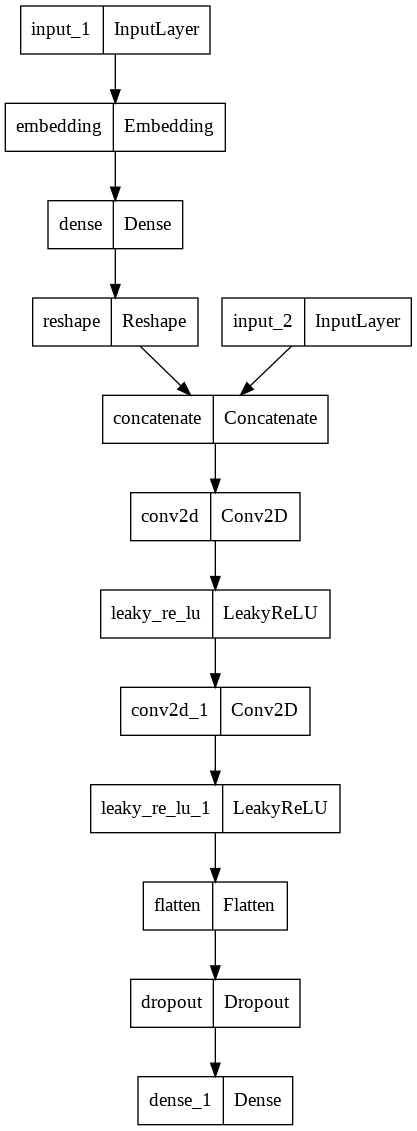

In [7]:
from tensorflow.keras.utils import plot_model

discriminator = _discriminator(input_shape=(28, 28, 1), n_classes=10)
plot_model(discriminator)

**Generator**

Generator có tác dụng là sinh ra ảnh fake. Do đó đây là một mô hình image2image và chúng ta cần sử dụng kiến trúc mạng giải chập để biến đổi các features ngược trở lại ảnh gốc.

Đầu vào của generator cũng bao gồm 2 nhánh, một nhánh là véc tơ noise gồm 100 chiều tương tự như trong model DCGAN. Nhánh còn lại ghi nhận thông tin về nhãn của ảnh mà chúng ta muốn mô hình biến đổi. Nhãn sẽ được one-hot encoding để tạo thành những thông tin mới được xem như là điều kiện để model geneartor tạo ra ảnh.

Hai nhánh sau đó được concatenate với nhau tạo ra một input vừa chứa đầu vào là véc tơ ngẫu nhiên  và vừa chứa điều kiện về nhãn . Do đó chúng ta có thể kiểm soát được bức ảnh sinh ra thông qua việc điều chỉnh điều kiện .

Một mạng giải chập được sử dụng để tăng dần kích thước các layers về bằng với bức ảnh gốc.

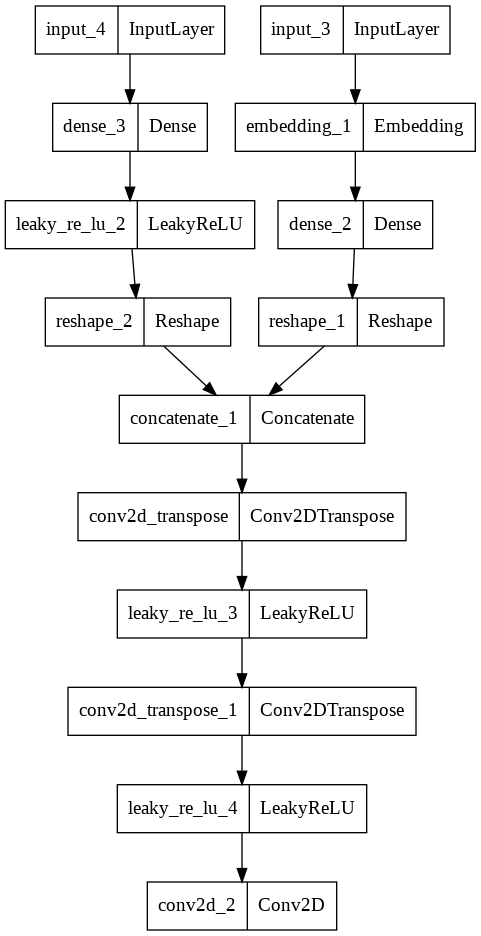

In [8]:
def _generator(latent_dim=100, n_classes=10):
  # 1. Khởi tạo nhánh đầu vào là y_label
  y_label = Input(shape=(1,))
  # embedding véc tơ categorical đầu vào
  li = Embedding(n_classes, 50)(y_label)
  n_shape = 7 * 7
  li = Dense(n_shape)(li)
  # reshape lại đầu vào về kích thước 7x7x1 như một channel bổ sung.
  li = Reshape((7, 7, 1))(li)

  # 2. Khởi tạo nhánh đầu vào là véc tơ noise x
  in_lat = Input(shape=(latent_dim,))
  n_shape = 128 * 7 * 7
  gen = Dense(n_shape)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Biến đổi về kích thước 7x7x128
  gen = Reshape((7, 7, 128))(gen)

  # 3. Merge nhánh 1 và nhánh 2
  merge = Concatenate()([gen, li])

  # 4. Sử dụng Conv2DTranspose để giải chập về kích thước ban đầu.
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # model
  model = Model([in_lat, y_label], out_layer)
  return model

generator = _generator(latent_dim=100, n_classes=10)
plot_model(generator)

**CGAN model**

Tiếp theo chúng ta sẽ cùng khởi tạo model CGAN từ hai model generator và discriminator.

Đầu tiên dữ liệu sẽ được truyền qua generator model để thu được đầu ra là một bức ảnh. Lưu ý input của generator trong CGAN ngoài véc tơ noise sẽ có thêm label so với model GAN.

Tiếp theo output của generator sẽ được truyền vào model discriminator để phân biệt ảnh real và ảnh fake. Input của discriminator cũng bao gồm ảnh được sinh ra từ generator và label.

CGAN model sẽ là một pipeline end2end kết hợp generator và discriminator. Chúng ta sẽ thông qua CGAN để huấn luyện generator. Do đó discriminator sẽ được đóng băng.

Hàm loss function của CGAN sẽ giống như DCGAN và là một hàm dạng binary_crossentropy.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


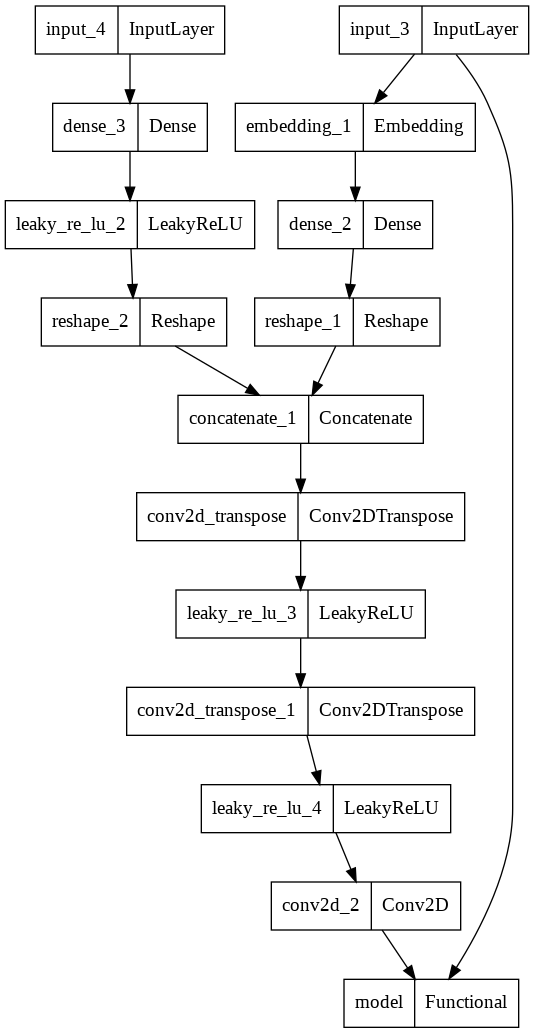

In [10]:
def _cgan(g_model, d_model):
	# Do cgan được sử dụng để huấn luyện generator nên discriminator sẽ được đóng băng
	d_model.trainable = False
	# Lấy đầu vào của generator model bao gồm véc tơ noise và nhãn
	gen_noise, gen_label = g_model.input
	# Lấy ảnh sinh ra từ generator model
	gen_output = g_model.output
	# Truyền output và nhãn của mô hình generator vào mô hình discriminator
	gan_output = d_model([gen_output, gen_label])
	# Khởi tạo mô hình CGAN
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

cgan_model = _cgan(generator, discriminator)
plot_model(cgan_model)

Để quá trình huấn luyện ổn định hơn chúng ta sẽ chuẩn hóa các giá trị cường độ pixel ảnh về khoảng [-1,1] thông qua công thức.

In [11]:
# Hàm chuẩn hóa dữ liệu huấn luyện
def _standardize_data(X_train, y_train):
	X = np.expand_dims(X_train, axis=-1)
	X = X.astype('float32')
  # chuẩn hóa dữ liệu về khoảng [-1, 1]
	X = (X - 127.5) / 127.5
	return [X, y_train]

In [18]:
print(X_train.shape)
X = np.expand_dims(X_train, axis=-1) #X_train 
print(X.shape)
print(y_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
(60000,)


Tiếp theo chúng ta sẽ lựa chọn ra ngẫu nhiên **n_samples** từ dữ liệu thật làm ảnh real để huấn luyện mô hình



In [12]:
# Lựa chọn ngẫu nhiên các dữ liệu huấn luyện
def _generate_real_samples(dataset, n_samples):
	images, labels = dataset
	# Lựa chọn n_samples index ảnh
	ix = np.random.randint(0, images.shape[0], n_samples)
	# Lựa chọn ngẫu nhiên n_sample từ index.
	X, labels = images[ix], labels[ix]
  # Khởi tạo nhãn 1 cho ảnh real
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [28]:
images, labels = dataset
print(images.shape)
print(labels.shape)
n_samples = 64
ix = np.random.randint(0, images.shape[0], n_samples)
print(ix) # Random index from 0 to 60000
X, labels = images[ix], labels[ix]
# Khởi tạo nhãn 1 cho ảnh real
y = np.ones((n_samples, 1))
print(X.shape)
print(labels.shape)
print(labels[0])
print(y.shape)
print(y[0])

(60000, 28, 28, 1)
(60000,)
[56912 19656 44455 58799 12910 33367 39703 18269 30942 49441 43356 11100
 43914 30306 39282  1739 26251 51967 33901 31816  7760 41262  8376 49404
 32559 14277 32426 58267  9276 35099 18607 55524 53076 11670 10436 35534
 15709  1014 59996 16374 11736  4518   594 58394  7690 24910 14700 16087
 28884 19700 19490 22493 53241 38727 25965 40528 10507 19442  3593 50693
 18984 28084 54630 16922]
(64, 28, 28, 1)
(64,)
9
(64, 1)
[1.]


Tương tự chúng ta cũng tạo ra một batch gồm n_samples từ dữ liệu fake được sinh ra từ generator model.

In [13]:
# Sinh ra các véc tơ noise trong không gian latent space làm đầu vào cho generator
def _generate_latent_points(latent_dim, n_samples, n_classes=10):
	# Khởi tạo các points trong latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape thành batch để feed vào generator.
	z_input = x_input.reshape(n_samples, latent_dim)
	# khởi tạo labels một cách ngẫu nhiên.
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# Sử dụng generator để sinh ra n_samples ảnh fake.
def _generate_fake_samples(generator, latent_dim, n_samples):
	# Khởi tạo các điểm ngẫu nhiên trong latent space.
	z_input, labels_input = _generate_latent_points(latent_dim, n_samples)
	# Dự đoán outputs từ generator
	images = generator.predict([z_input, labels_input]) 
	# Khởi tạo nhãn 0 cho ảnh fake
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [33]:
latent_dim = 100
x_input = np.random.randn(latent_dim * n_samples)
print(x_input.shape)
# reshape thành batch để feed vào generator.
z_input = x_input.reshape(n_samples, latent_dim)
print(z_input.shape)
# khởi tạo labels một cách ngẫu nhiên.
labels = np.random.randint(0, 10, n_samples)
print(labels)

(6400,)
(64, 100)
[1 3 5 4 2 7 4 6 6 3 7 5 1 4 0 3 1 0 1 1 2 9 9 6 6 3 6 8 8 3 0 2 5 9 2 0 5
 5 8 1 1 2 4 7 7 0 2 3 5 7 7 5 5 1 8 7 6 3 1 6 4 8 0 1]


Tiếp theo chúng ta sẽ huấn luyện mô hình một cách xen kẽ giữa generator và discriminator. Quá trình huấn luyện trên mỗi batch như sau:

Huấn luyện mô hình trên discriminator trước. Trong đó 1/2 batch là ảnh real và 1/2 batch còn lại là ảnh fake.

Huấn luyện mô hình trên generator thông qua huấn luyện model CGAN trên 1 batch.
Sau mỗi mặc định 10 epochs thì model CGAN sẽ được lưu lại.

In [14]:
def _train(g_model, d_model, cgan_model, dataset, latent_dim, n_epochs=100, n_batch=128, save_every_epochs=10):
	'''
	g_model: generator model
	d_model: discriminator model
	cgan_model: gan_model
	dataset: dữ liệu huấn luyện, bao gồm: (X_train, y_train)
	latent_dim: Số chiều của latent space
	n_epochs: Số lượng epochs
	n_batch: Kích thước batch_size
	save_every_epochs: Số lượng epochs mà chúng ta sẽ save model.
	'''
	# Tính số lượng batch trên một epochs
	batch_per_epoch = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# Huấn luyện mô hình qua từng epochs
	for i in range(n_epochs):
		# Khởi tạo batch trên tập train
		for j in range(batch_per_epoch):
			# 1. Huấn luyện model discrinator
			# Khởi tạo batch cho ảnh real ngẫu nhiên
			[X_real, labels_real], y_real = _generate_real_samples(dataset, half_batch)
			# Cập nhật discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# Khởi tạo batch cho ảnh fake ngẫu nhiên
			[X_fake, labels], y_fake = _generate_fake_samples(g_model, latent_dim, half_batch)
			# Cập nhật weights cho discriminator model
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
	 		# 2. Huấn luyện model generator
			# Khởi tạo các điểm ngẫu nhiên trong latent space như là đầu vào cho generator
			[z_input, labels_input] = _generate_latent_points(latent_dim, n_batch)
			# Khởi tạo nhãn discriminator cho các dữ liệu fake. Do chúng ta giả định là generator đánh lừa được discriminator nên nhãn của ảnh là 1.
			y_gan = np.ones((n_batch, 1))
			# Huấn luyện generator thông qua model CGAN
			g_loss = cgan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
	if (i % save_every_epochs) & (i > 0):
		g_model.save('cgan_generator_epoch{}.h5'.format(i))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [ ]:
# Kích thước latent space
latent_dim = 100
# Khởi tạo discriminator
d_model = _discriminator()
# Khởi tạo generator
g_model = _generator(latent_dim)
# Khởi tạo cgan
cgan_model = _cgan(g_model, d_model)
# load image data
dataset = _standardize_data(X_train, y_train)
# train model
_train(g_model, d_model, cgan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 1/468, d1=0.751, d2=0.696 g=0.691
>1, 2/468, d1=0.658, d2=0.700 g=0.688
>1, 3/468, d1=0.601, d2=0.706 g=0.685
>1, 4/468, d1=0.545, d2=0.708 g=0.685
>1, 5/468, d1=0.491, d2=0.704 g=0.693
>1, 6/468, d1=0.442, d2=0.693 g=0.702
>1, 7/468, d1=0.385, d2=0.690 g=0.707
>1, 8/468, d1=0.326, d2=0.697 g=0.699
>1, 9/468, d1=0.286, d2=0.724 g=0.674
>1, 10/468, d1=0.237, d2=0.773 g=0.635
>1, 11/468, d1=0.208, d2=0.837 g=0.588
>1, 12/468, d1=0.194, d2=0.927 g=0.542
>1, 13/468, d1=0.181, d2=1.013 g=0.513
>1, 14/468, d1=0.188, d2=1.042 g=0.525
>1, 15/468, d1=0.214, d2=0.972 g=0.590
>1, 16/468, d1=0.249, d2=0.829 g=0.714
>1, 17/468, d1=0.282, d2=0.671 g=0.909
>1, 18/468, d1=0.339, d2=0.507 g=1.099
>1, 19/468, d1=0.330, d2=0.399 g=1.283
>1, 20/468, d1=0.343, d2=0.328 g=1.440
>1, 21/468, d1=0.359, d2=0.280 g=1.577
>1, 22/468, d1=0.371, d2=0.274 g=1.580
>1, 23/468, d1=0.359, d2=0.288 g=1.493
>1, 24/468, d1=0.373, d2=0.364 g=1.260
>1, 25/468, d1=0.313, d2=0.483 g=1.011
>1, 26/468, d1=0.233, d2=0.591 g=0